## Approaching Zeri data (Giulia)

What I did to approach Federico Zeri Foundation data:
1. in the Fondazione Zeri [SPARQL endpoint](http://data.fondazionezeri.unibo.it/query/) (available thanks to the [Zeri & LODE project](http://data.fondazionezeri.unibo.it/)) I ran some simple queries to randomly explore some classes and properties.
2. I then turned to official documentation to map OA Entries to RDF data, which can be downloaded [here](https://figshare.com/articles/journal_contribution/Mapping_OA_Entry_to_RDF/3175057).
3. However, what helped me the most in understanding the structure of the data was exploring it directly. It is in fact possible to access a huge part of the datatset thanks to a dump avaialble [here](http://amsacta.unibo.it/5497/). By directly consulting the OA files and exploring the online catalog, I was able to identify the classes and properties that were right for us. We will see them as the documentation continues.

**Discalimer**
I was still at the very beginning of my work when the SPARQL endpoint went down, and remained in such a state for a very long time. For this reason, I decided to continue working locally on a FUSEKI server (it took me 2 days and a half to uplod the dump). As a consequence, for the sake of the project, I decided to work with downloaded JSON files, and not with dynamic and live queries (we will see the only exception).

### Essential classes and properties
**PAINTING**

For the purpose of our research, we have decided to work exclusively with **paintings**, and not works of art in general.
Therefore, this was a first "requirement" in the reasearch.


In [18]:
# fabio:ArtisticWork crm:P2_has_type crm:E55_Type .
# fabio:ArtisticWork rdf:type crm:E28_Conceptual_Object .

With this few elements we can immediately know how many paintings are in Zeri:

In [59]:
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
zeri_endpoint = "http://data.fondazionezeri.unibo.it/sparql"

paintings_query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT DISTINCT ?artwork
WHERE {
    ?artwork rdf:type crm:E28_Conceptual_Object;
    crm:P2_has_type <https://w3id.org/zericatalog/object/painting> .
}
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(zeri_endpoint)
# set the query
sparql_wd.setQuery(paintings_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
paintings_num_results = sparql_wd.query().convert()

paintings_num = len(paintings_num_results['results']['bindings'])
print(f'The total number of paintings is {paintings_num}.')

The total number of paintings is 15661.


**PROVENANCE**

Secondly, as an additional requirement of our reasearch, we wanted to work with paintings that had been subject *at least once* of an **act of provenance**. This implies that the custody of the painting is transferred from a **giving institution** to an **acquiring one**.

We will deal with the institutions later. What interests us now is the act of provenance, identified by the *crm:E10_Transfer_of_Custody* class.

In [60]:
# crm:E10_Transfer_of_Custody crm:P30_transferred_custody_of fabio:AnalogItem .
# fabio:AnalogItem rdf:type crm:E84_Information_Carrier .

Before proceeding further, we need to bound this AnalogItem class to the ArtisticWork class, in order to specify that we want **paintings**. Both of them are described by the *oaentry:OAEntry* class:

In [61]:
# oaentry:OAEntry oaentry:describes fabio:ArtisticWork, fabio:AnalogItem .

provenance_paintings_query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>

SELECT DISTINCT ?art_item ?provenance
WHERE {
  ?oaentry oaentry:describes ?artwork, ?art_item .
  ?artwork rdf:type crm:E28_Conceptual_Object;
    crm:P2_has_type <https://w3id.org/zericatalog/object/painting> .
  
  ?art_item rdf:type crm:E84_Information_Carrier.
  ?provenance crm:P30_transferred_custody_of ?art_item .
} ORDER BY ?art_item
"""

sparql_wd = SPARQLWrapper(zeri_endpoint)
# set the query
sparql_wd.setQuery(provenance_paintings_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
provenance_paintings_results = sparql_wd.query().convert()

for result in provenance_paintings_results['results']['bindings'][:20]: # just to show an example
    art_item = result['art_item']['value']
    provenance = result['provenance']['value']
    print(f'Art item {art_item} has provenance \"{provenance}\".')

Art item https://w3id.org/zericatalog/artwork/16528/item has provenance "https://w3id.org/zericatalog/artwork/16528/provenance-1".
Art item https://w3id.org/zericatalog/artwork/16537/item has provenance "https://w3id.org/zericatalog/artwork/16537/provenance-1".
Art item https://w3id.org/zericatalog/artwork/16537/item has provenance "https://w3id.org/zericatalog/artwork/16537/provenance-2".
Art item https://w3id.org/zericatalog/artwork/16537/item has provenance "https://w3id.org/zericatalog/artwork/16537/provenance-3".
Art item https://w3id.org/zericatalog/artwork/16540/item has provenance "https://w3id.org/zericatalog/artwork/16540/provenance-1".
Art item https://w3id.org/zericatalog/artwork/16540/item has provenance "https://w3id.org/zericatalog/artwork/16540/provenance-2".
Art item https://w3id.org/zericatalog/artwork/16540/item has provenance "https://w3id.org/zericatalog/artwork/16540/provenance-3".
Art item https://w3id.org/zericatalog/artwork/16603/item has provenance "https://w3

What we immediately notice is that one painting can have more than one act of provenance.
Let's discover how mani unique paintings have at least one act of provenance among the initial 15661 total.

In [62]:
paintings_with_provenance = set()
for result in provenance_paintings_results['results']['bindings']:
    art_item = result['art_item']['value']
    paintings_with_provenance.add(art_item)
paintings_with_provenance_num = len(paintings_with_provenance)
print(f'Of {paintings_num} paintings only {paintings_with_provenance_num} of them have at least one act of provenance.')

Of 15661 paintings only 3798 of them have at least one act of provenance.


Now we have the number of paitings we want to work with: **3798**.

**CURRENT LOCATION**

A first key factor in our reasearch was to understand where there paitings are **currently located**, after having moved at least once (we will deepen the various aspects of provenance later on).

Now we have two possibilities:
1. we directly retrieve the current location (crm:E53_place)
2. we see which institution (crm:E39_Actor) is the **current keeper** of the painting, and as a consequence retrieve its location (crm:E53_place)

In [63]:
# fabio:AnalogItem crm:P55_has_current_location crm:E53_Place .

current_location_query_01 = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>

SELECT DISTINCT ?art_item ?current_location
WHERE {
  ?oaentry oaentry:describes ?artwork, ?art_item .
  ?artwork rdf:type crm:E28_Conceptual_Object;
    crm:P2_has_type <https://w3id.org/zericatalog/object/painting> .
    
  ?art_item rdf:type crm:E84_Information_Carrier.
  ?provenance crm:P30_transferred_custody_of ?art_item .
  
  ?art_item crm:P55_has_current_location ?current_location .
} ORDER BY ?art_item
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(zeri_endpoint)
# set the query
sparql_wd.setQuery(current_location_query_01)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
current_location_results_01 = sparql_wd.query().convert()

for result in current_location_results_01['results']['bindings'][:20]: # just to show an example
    art_item = result['art_item']['value']
    current_location = result['current_location']['value']
    print(f'Art item {art_item} has current location \"{current_location}\".')

Art item https://w3id.org/zericatalog/artwork/16528/item has current location "Palazzo degli Uffizi, Galleria degli Uffizi, collocazione".
Art item https://w3id.org/zericatalog/artwork/16537/item has current location "National Gallery of Victoria, collocazione".
Art item https://w3id.org/zericatalog/artwork/16540/item has current location "National Gallery of Art, collocazione".
Art item https://w3id.org/zericatalog/artwork/16624/item has current location "Lowe Art Museum, University of Miami, collocazione".
Art item https://w3id.org/zericatalog/artwork/16632/item has current location "Palazzo Pitti, Galleria Palatina e Appartamenti Reali, collocazione".
Art item https://w3id.org/zericatalog/artwork/16633/item has current location "The Metropolitan Museum of Art, collocazione".
Art item https://w3id.org/zericatalog/artwork/16638/item has current location "National Gallery of Art, collocazione".
Art item https://w3id.org/zericatalog/artwork/16641/item has current location "Fitzwilliam M

In [64]:
paintings_with_current_location_01 = len(current_location_results_01['results']['bindings'])
print(f'Of {paintings_with_provenance_num} paintings with at least one act of provenance, only {paintings_with_current_location_01} of them have a known current location.')

Of 3798 paintings with at least one act of provenance, only 2947 of them have a known current location.


In [81]:
# fabio:AnalogItem crm:P50_has_current_keeper crm:E39_Actor .
# crm:E39_Actor crm:P74_has_current_or_former_residence crm:E53_place .

current_location_query_02 = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>

SELECT DISTINCT ?art_item ?current_inst ?current_place
WHERE {
  ?oaentry oaentry:describes ?artwork, ?art_item .
  ?artwork rdf:type crm:E28_Conceptual_Object;
    crm:P2_has_type <https://w3id.org/zericatalog/object/painting> .
  
  ?art_item rdf:type crm:E84_Information_Carrier.
  ?provenance crm:P30_transferred_custody_of ?art_item .
  
  ?art_item crm:P50_has_current_keeper ?current_inst .
  OPTIONAL {?current_inst crm:P74_has_current_or_former_residence ?current_place .}
} ORDER BY ?art_item
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(zeri_endpoint)
# set the query
sparql_wd.setQuery(current_location_query_02)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
current_location_results_02 = sparql_wd.query().convert()

for result in current_location_results_02['results']['bindings'][:100]: # just to show an example
    art_item = result['art_item']['value']
    current_institution = result['current_inst']['value']
    if "current_place" in result:
        current_place = result['current_place']['value']
        print(f'Art item {art_item} has current keeper \"{current_institution}\" at location \"{current_place}\".')
    else:
        print(f'Art item {art_item} has unknown location.')
    

Art item https://w3id.org/zericatalog/artwork/16528/item has current keeper "https://w3id.org/zericatalog/palazzo-degli-uffizi-galleria-degli-uffizi-firenze" at location "https://w3id.org/zericatalog/place/firenze".
Art item https://w3id.org/zericatalog/artwork/16537/item has current keeper "https://w3id.org/zericatalog/national-gallery-of-victoria-melbourne" at location "https://w3id.org/zericatalog/place/melbourne".
Art item https://w3id.org/zericatalog/artwork/16540/item has current keeper "https://w3id.org/zericatalog/national-gallery-of-art-washington-dc" at location "https://w3id.org/zericatalog/place/washington-dc".
Art item https://w3id.org/zericatalog/artwork/16603/item has current keeper "https://w3id.org/zericatalog/chiesa-del-corpus-christi-roma" at location "https://w3id.org/zericatalog/place/roma".
Art item https://w3id.org/zericatalog/artwork/16605/item has current keeper "https://w3id.org/zericatalog/gemaldegalerie-staatliche-museen-zu-berlin-berlino" at location "https

In [82]:
paintings_with_current_location_02 = len(current_location_results_02['results']['bindings'])
print(f'Of {paintings_with_provenance_num} paintings with at least one act of provenance, only {paintings_with_current_location_02} of them have a known current location.')

Of 3798 paintings with at least one act of provenance, only 5831 of them have a known current location.


That was strange. 
Eg. 6662/item has two results with same institution "collezione-privata-roma" and different iris for place: "roma" and "roma/district".
In other cases, the institution is unkwnon, hence the current place is, too. Noted, but let's understand how many known places we have:

In [84]:
current_places = dict()
for result in current_location_results_02['results']['bindings']:
    art_item = result['art_item']['value']
    if "current_place" in result:
        current_place = result['current_place']['value']
        current_places[art_item] = current_place

current_places_num = len(current_places)
print(f'Of {paintings_with_provenance_num} paintings with at least one act of provenance, only {current_places_num} of them have a known current location.')

Of 3798 paintings with at least one act of provenance, only 3705 of them have a known current location.


Why I decided to extract data following the second approach:
1. **2947** vs **3705**: the numbers speak for themselves, in the second case we have more information.
2. In the first case, we have information only about the institutional location (eg. "National Gallery of Art, collocazione"), while in the second case we have information both for the instituion that keeps the painting and the specific place (city, region, country, etc.).

For the purpose of our project, we wanted to visualize the *where* on a map. In order to do so, it proved necessary to trace the coordinates of each place. Luckily, thanks to LODLive the iri of a place is often (*but not always*) connected to the corresponding wikidata, geonames and DBpedia ones through the property *owl:sameAs*.

I decided to work with geonames because:
- the results were more numerous
- [GeoNames](http://www.geonames.org/) is a database (and has a connected ontology) that deals with geographic data specifically.

## Working with current place

As a result, the following is the SPARQL query used to download the 'current_place_geo.json' I worked with:

In [ ]:
current_place_query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT DISTINCT ?artwork ?current_inst ?current_place ?geo_place
WHERE {
  ?oaentry oaentry:describes ?artwork, ?art_item .
  ?artwork rdf:type crm:E28_Conceptual_Object;
    crm:P2_has_type <https://w3id.org/zericatalog/object/painting> .
  
  ?art_item rdf:type crm:E84_Information_Carrier.
  ?provenance crm:P30_transferred_custody_of ?art_item .
  
  ?art_item crm:P50_has_current_keeper ?current_inst .
  OPTIONAL {?current_inst crm:P74_has_current_or_former_residence ?current_place .
  OPTIONAL { ?current_place owl:sameAs ?geo_place FILTER regex(str(?geo_place), "geonames") . } }
} ORDER BY ?artwork
"""

Before we get into the code, some explanations are needed.
- To use the GeoNames API for free, I signed up and created an account which is used as a key.
- To manage the GeoNames data in an agile way, I imported the [geocoder package](https://geocoder.readthedocs.io/providers/GeoNames.html).
- Finally, I defined some functions that I reuse several times during my work.

In [96]:
import geocoder
from urllib.parse import urlparse
import json
import pprint
from collections import Counter
import csv

def read_json(json_file):
    """
    open and read JSON file
    """
    with open(json_file, 'r') as results:
        data = json.load(results)
        return data
    

def url_strip(url):
    """
    function to retrieve the last piece of an url (path)
    """
    url_path = urlparse(url).path  # retrieve path
    last_piece = url_path.split('/')[-1]  # separate by '/'' and keep only the last part
    return last_piece


def district_strip(last_piece):
    """
    when necessary, strip the district portion from the remaining part of the url
    """
    if 'district' in last_piece:
        no_district = last_piece.split('-')  # separate by '-'
        no_district.pop()  # remove last part (district)
        return ' '.join(no_district)  # join again with space as separator
    else:
        return last_piece


def get_geoid(geo_name):
    """
    from name (eg. Firenze) retrieve the geo_id in geonames
    """
    place = geocoder.geonames(geo_name,
                              key='giuliarenda')
    geo_id = place.geonames_id
    return geo_id

 
def access_geo_details(geo_id):
    """
    from geoi_id, access all the info we need
    """
    place_info = geocoder.geonames(geo_id, method='details', key='mondoboia')
    return place_info


def get_coord_info(place_info):
    """
    from access_geo_details, get name and coord
    """
    city = place_info.address
    latitude = place_info.lat
    longitude = place_info.lng
    return city, latitude, longitude

# acces file
zeri_data = read_json('current_place_geo.json')

# first of all, I need to make sure that artworks are not repeated. For this reason,
# I create a dictionary with (artwork-current_place) value pairs.

places_dict = dict()
unknown_locations = dict()
geo_id_set = set() # to make life easier later: this will drastically decrease the call to Geonames
places_set = set()
for zeri_result in zeri_data['results']['bindings']:
    artwork_value = zeri_result['artwork']['value']
    if 'geo_place' in zeri_result:
        geo_place = zeri_result['geo_place']['value']
        places_dict[artwork_value] = url_strip(geo_place)
        geo_id_set.add(url_strip(geo_place))  # add to set only the id in the path part of the url
    else:
        if 'current_place' in zeri_result:
            current_place = zeri_result['current_place']['value']
            place_name = district_strip(url_strip(current_place)) # easier to work with shorter and cleaner strings
            places_dict[artwork_value] = place_name
            places_set.add(place_name)  # I also store the place_name into a set,to use it later for the call to geonames
        else:
            unknown_locations[artwork_value] = 'Unknown location'
# pprint.pprint(places_dict)
# print(places_set)
# print(geo_id_set)
# print(len(places_dict))
# print(len(places_set))
# print(len(places_dict))

In [97]:
print(f'{len(unknown_locations)} paintings have an unknown location.')
print(f'We have {len(places_set)} unique places and {len(geo_id_set)} GeoNames id_numbers.')

93 paintings have an unknown location.
We have 135 unique places and 280 GeoNames id_numbers.


In [98]:
print(f'The dictionary with paintings has {len(places_dict)} results: \n {places_dict}')

The dictionary with paintings has 3705 results: 
 {'https://w3id.org/zericatalog/artwork/16528': '3176959', 'https://w3id.org/zericatalog/artwork/16537': '2158177', 'https://w3id.org/zericatalog/artwork/16540': '4140963', 'https://w3id.org/zericatalog/artwork/16603': '3169069', 'https://w3id.org/zericatalog/artwork/16605': '2950159', 'https://w3id.org/zericatalog/artwork/16606': '2643743', 'https://w3id.org/zericatalog/artwork/16624': 'coral-gables-fl', 'https://w3id.org/zericatalog/artwork/16632': '3176959', 'https://w3id.org/zericatalog/artwork/16633': 'new-york-ny', 'https://w3id.org/zericatalog/artwork/16636': '3117735', 'https://w3id.org/zericatalog/artwork/16638': '4140963', 'https://w3id.org/zericatalog/artwork/16641': '2653941', 'https://w3id.org/zericatalog/artwork/16642': 'roma', 'https://w3id.org/zericatalog/artwork/16662': '3169069', 'https://w3id.org/zericatalog/artwork/16665': '3169069', 'https://w3id.org/zericatalog/artwork/16666': '3169069', 'https://w3id.org/zericatalo

In [99]:
# now that I have the correct number of results, I can proceed with the search of geo_info

# first, I work with the geo_ids because it's faster
coord_dict = dict()
to_be_found = list()
for geo_id in geo_id_set:
    geo_info = access_geo_details(geo_id)
    country_name = geo_info.country
    country_id = geo_info.country_geonames_id
    country_info = access_geo_details(country_id)
    country_coord = (country_info.lat, country_info.lng)
    coord_dict[geo_id] = (country_name, country_coord)

pprint.pprint(coord_dict)

{'1819729': ('Hong Kong', ('22.25', '114.16667')),
 '1850147': ('Japan', ('35.68536', '139.75309')),
 '2077456': ('Australia', ('-25', '135')),
 '2147714': ('Australia', ('-25', '135')),
 '2158177': ('Australia', ('-25', '135')),
 '2193773': ('New Zealand', ('-42', '174')),
 '2267057': ('Portugal', ('39.6945', '-8.13057')),
 '2503147': ('Algeria', ('28', '3')),
 '2510769': ('Spain', ('40', '-4')),
 '2523920': ('Italy', ('42.83333', '12.83333')),
 '2523964': ('Italy', ('42.83333', '12.83333')),
 '2524170': ('Italy', ('42.83333', '12.83333')),
 '2525073': ('Italy', ('42.83333', '12.83333')),
 '2525473': ('Italy', ('42.83333', '12.83333')),
 '2618425': ('Denmark', ('56', '10')),
 '2620473': ('Denmark', ('56', '10')),
 '2633352': ('United Kingdom', ('54.75844', '-2.69531')),
 '2635167': ('United Kingdom', ('54.75844', '-2.69531')),
 '2637487': ('United Kingdom', ('54.75844', '-2.69531')),
 '2638077': ('United Kingdom', ('54.75844', '-2.69531')),
 '2640729': ('United Kingdom', ('54.75844', 

In [100]:
# second, I work with place names
to_be_found = list()  # in case a place is not found in geonames
for place in places_set:
    geo_id = get_geoid(place)
    if geo_id is not None:
        geo_info = access_geo_details(geo_id)
        country_name = geo_info.country
        country_id = geo_info.country_geonames_id
        country_info = access_geo_details(country_id)
        country_coord = (country_info.lat, country_info.lng)
        coord_dict[place] = (country_name, country_coord)
    else:
        to_be_found.append(place)
pprint.pprint(coord_dict)

Status code 404 from http://api.geonames.org/getJSON: ERROR - 404 Client Error: Not Found for url: http://api.geonames.org/getJSON?geonameId=0&username=mondoboia&style=full


{'1819729': ('Hong Kong', ('22.25', '114.16667')),
 '1850147': ('Japan', ('35.68536', '139.75309')),
 '2077456': ('Australia', ('-25', '135')),
 '2147714': ('Australia', ('-25', '135')),
 '2158177': ('Australia', ('-25', '135')),
 '2193773': ('New Zealand', ('-42', '174')),
 '2267057': ('Portugal', ('39.6945', '-8.13057')),
 '2503147': ('Algeria', ('28', '3')),
 '2510769': ('Spain', ('40', '-4')),
 '2523920': ('Italy', ('42.83333', '12.83333')),
 '2523964': ('Italy', ('42.83333', '12.83333')),
 '2524170': ('Italy', ('42.83333', '12.83333')),
 '2525073': ('Italy', ('42.83333', '12.83333')),
 '2525473': ('Italy', ('42.83333', '12.83333')),
 '2618425': ('Denmark', ('56', '10')),
 '2620473': ('Denmark', ('56', '10')),
 '2633352': ('United Kingdom', ('54.75844', '-2.69531')),
 '2635167': ('United Kingdom', ('54.75844', '-2.69531')),
 '2637487': ('United Kingdom', ('54.75844', '-2.69531')),
 '2638077': ('United Kingdom', ('54.75844', '-2.69531')),
 '2640729': ('United Kingdom', ('54.75844', 

In [104]:
print(f'Place not found in geonames: {to_be_found}')

Place not found in geonames: ['ardencraig', 'garrowby-hall']


Since the places that have no correspondence in GeoNames are only two, they can be overlooked because they won't change significantly the results.

In [106]:
coord_list = list()  # where to store the coordinates of each country

for artwork_value, place_name in places_dict.items():
    for place, country_info in coord_dict.items():
        if place_name == place:
            coord_list.append(country_info)

country_counter = Counter(coord_list)
print(f'How many times the same coordinates are repeated:\n {country_counter}')

How many times the same coordinates are repeated:
 Counter({('Italy', ('42.83333', '12.83333')): 1496, ('United States', ('39.76', '-98.5')): 1139, ('United Kingdom', ('54.75844', '-2.69531')): 570, ('France', ('46', '2')): 144, ('Germany', ('51.5', '10.5')): 83, ('Switzerland', ('47.00016', '8.01427')): 62, ('Spain', ('40', '-4')): 26, ('Russia', ('60', '100')): 21, ('Austria', ('47.33333', '13.33333')): 19, ('Netherlands', ('52.25', '5.75')): 17, ('Hungary', ('47', '20')): 14, ('Ireland', ('53', '-8')): 13, ('Canada', ('60.10867', '-113.64258')): 11, ('Australia', ('-25', '135')): 10, ('Monaco', ('43.73141', '7.41903')): 9, ('Slovenia', ('46.08333', '15')): 8, ('Sweden', ('62', '15')): 7, ('Brazil', ('-10', '-55')): 7, ('Poland', ('52', '20')): 7, ('Vatican City', ('41.90225', '12.4533')): 6, ('Puerto Rico', ('18.24829', '-66.49989')): 5, ('Czechia', ('49.75', '15')): 5, ('Denmark', ('56', '10')): 4, ('Japan', ('35.68536', '139.75309')): 2, ('Belgium', ('50.75', '4.5')): 2, ('Syria',

What is left to do is export the data into a csv file for Marina to work on.

In [107]:
# export as csv file
header = ['country', 'latitude', 'longitude', 'painting_num']
a_file = open('count_country_coord.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(a_file)
writer.writerow(header)
for key, value in country_counter.items():
    writer.writerow([key[0], key[1][0], key[1][1], value])
a_file.close()

# MARINA PART

WORD WORD WORD

## Working with provenance (Giulia)

As already mentioned, provenance is the act for which the custody of the painting is transferred from a giving institution to an acquiring one.

In [ ]:
# crm:E39_Actor crm:P29i_received_custody_through crm:E10_Transfer_of_Custody .
# crm:E10_Transfer_of_Custody crm:P28_custody_surrendered_by crm:E39_Actor .

With this additionl piece of information and previous knowledge, I can now create the query to retrieve the paintings, their acts of provenance and respective giving-acquiring institutions, with places.

The following is the SPARQL query used to download the 'provenance.json' I worked with:

In [ ]:
provenance_query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT DISTINCT ?art_item ?provenance ?acquiring_city ?acquiring_inst ?giving_city ?giving_inst
WHERE {
  ?oaentry oaentry:describes ?artwork, ?art_item .
  ?artwork rdf:type crm:E28_Conceptual_Object;
    crm:P2_has_type <https://w3id.org/zericatalog/object/painting> .
  
  ?art_item rdf:type crm:E84_Information_Carrier.
  ?provenance crm:P30_transferred_custody_of ?art_item .
  
  ?provenance crm:P28_custody_surrendered_by ?giving_inst .
  OPTIONAL { ?giving_inst crm:P74_has_current_or_former_residence ?giving_city . }
  ?acquiring_inst crm:P29i_received_custody_through ?provenance .
  OPTIONAL { ?acquiring_inst crm:P74_has_current_or_former_residence ?acquiring_city . }
  
} ORDER BY ?art_item
"""

## How much is it possible to analyse provenance (Elisa)

As one of the first things in our research, we are interested in understanding how much it is possible to analyse provenance with the data available into the Zeri Catalogue. Consulting its LOD, we discover that there is a specific entry related to the provenance acts referred to each painting. Working with the data provided by Giulia, we are able to conduct some analysis on  items in the collection are described through their provenance and, thanks to this, recover an historical of which has been in time their  giving city or institution - which is the entity that gave away the painting during that act - and the acquiring city or institution - which is the entity that acquired that painting during that act.

All the analysis here reported are conducted on data stored in a .json file named 'provenance.json' where each painting and its related exchanging acts are organized in the following format:

In [ ]:
#       {
#         "art_item": { "type": "uri" , "value": "https://w3id.org/zericatalog/artwork/16528/item" } ,
#         "provenance": { "type": "uri" , "value": "https://w3id.org/zericatalog/artwork/16528/provenance-1" } ,
#         "acquiring_city": { "type": "uri" , "value": "https://w3id.org/zericatalog/place/firenze" } ,
#         "acquiring_inst": { "type": "uri" , "value": "https://w3id.org/zericatalog/palazzo-degli-uffizi-galleria-degli-uffizi-firenze" } ,
#         "giving_city": { "type": "uri" , "value": "https://w3id.org/zericatalog/place/firenze" } ,
#         "giving_inst": { "type": "uri" , "value": "https://w3id.org/zericatalog/palazzo-uguccioni-firenze" }
#       }

# Import the json file with information about provenance

import json
with open('provenance.json', encoding='utf-8') as fh:
    data = json.load(fh)

Then, we create a default dictionary where each key has as value a list. Dictionary keys are the URIs of the items
in the catalogue, while dictionary values are lists where to append each provenance act related to a certain
item. In this way, we manage to gather together all the act of provenances referred to a certain item through its ID.

We clean the outcoming dictionary by assigning at each item the higher value of provenance elaborated
in order to have only the numerical value of the act of provenance. In this way we manage to store the
number of act of provenance referred to a single item.

In [108]:
from collections import defaultdict

paintings_dict = defaultdict(list)
for i in data['results']['bindings']:
    art_item = i['art_item']['value']
    provenances = i['provenance']['value']
    provenance_num = url_strip(provenances).split('-')[-1]  # to retrieve only the number
    paintings_dict[art_item].append(int(provenance_num))
print(paintings_dict)

defaultdict(<class 'list'>, {'https://w3id.org/zericatalog/artwork/16528/item': [1], 'https://w3id.org/zericatalog/artwork/16537/item': [3, 1, 2], 'https://w3id.org/zericatalog/artwork/16540/item': [2, 3, 3, 1], 'https://w3id.org/zericatalog/artwork/16603/item': [1], 'https://w3id.org/zericatalog/artwork/16605/item': [1, 2, 3], 'https://w3id.org/zericatalog/artwork/16606/item': [1], 'https://w3id.org/zericatalog/artwork/16624/item': [10, 1, 9, 8, 7, 6, 5, 4, 2, 3], 'https://w3id.org/zericatalog/artwork/16632/item': [2, 1], 'https://w3id.org/zericatalog/artwork/16633/item': [2, 3, 1, 4], 'https://w3id.org/zericatalog/artwork/16636/item': [1], 'https://w3id.org/zericatalog/artwork/16638/item': [2, 1], 'https://w3id.org/zericatalog/artwork/16641/item': [1, 2], 'https://w3id.org/zericatalog/artwork/16642/item': [1, 1], 'https://w3id.org/zericatalog/artwork/16662/item': [1], 'https://w3id.org/zericatalog/artwork/16665/item': [1], 'https://w3id.org/zericatalog/artwork/16666/item': [1], 'http

In [109]:
# We use only the maximum value present in each list

paintings_provenance_dict = dict()
for k, v in paintings_dict.items():
    max_value = max(v)
    paintings_provenance_dict[k] = max_value
print(paintings_provenance_dict)

{'https://w3id.org/zericatalog/artwork/16528/item': 1, 'https://w3id.org/zericatalog/artwork/16537/item': 3, 'https://w3id.org/zericatalog/artwork/16540/item': 3, 'https://w3id.org/zericatalog/artwork/16603/item': 1, 'https://w3id.org/zericatalog/artwork/16605/item': 3, 'https://w3id.org/zericatalog/artwork/16606/item': 1, 'https://w3id.org/zericatalog/artwork/16624/item': 10, 'https://w3id.org/zericatalog/artwork/16632/item': 2, 'https://w3id.org/zericatalog/artwork/16633/item': 4, 'https://w3id.org/zericatalog/artwork/16636/item': 1, 'https://w3id.org/zericatalog/artwork/16638/item': 2, 'https://w3id.org/zericatalog/artwork/16641/item': 2, 'https://w3id.org/zericatalog/artwork/16642/item': 1, 'https://w3id.org/zericatalog/artwork/16662/item': 1, 'https://w3id.org/zericatalog/artwork/16665/item': 1, 'https://w3id.org/zericatalog/artwork/16666/item': 1, 'https://w3id.org/zericatalog/artwork/16676/item': 2, 'https://w3id.org/zericatalog/artwork/16684/item': 1, 'https://w3id.org/zericata

And we visualize the outcoming results in a pandas dataframe with item IDs and number of exchanging acts related to them.

In [110]:
import pandas as pd
df = pd.DataFrame.from_dict(paintings_provenance_dict, orient='index', columns=['provenance nr'])
print(df)

                                                 provenance nr
https://w3id.org/zericatalog/artwork/16528/item              1
https://w3id.org/zericatalog/artwork/16537/item              3
https://w3id.org/zericatalog/artwork/16540/item              3
https://w3id.org/zericatalog/artwork/16603/item              1
https://w3id.org/zericatalog/artwork/16605/item              3
...                                                        ...
https://w3id.org/zericatalog/artwork/62128/item              2
https://w3id.org/zericatalog/artwork/80910/item             10
https://w3id.org/zericatalog/artwork/85954/item              3
https://w3id.org/zericatalog/artwork/85955/item              3
https://w3id.org/zericatalog/artwork/91084/item              1

[3798 rows x 1 columns]


Finally, we count how many items in the collections have been subjected to at least an act of exchange described
through provenance.

In [111]:
print('Nr of paintings having at least one provenance', len(paintings_provenance_dict))

Nr of paintings having at least one provenance 3798


And then the average amount of exchanging acts computed on the overall number of paintings

In [112]:
print('Average provenance of Italian paintings', df.mean())

Average provenance of Italian paintings provenance nr    1.746709
dtype: float64


#### ACQUISITIONS AND GIVING AWAY
In order to inspect Italian painting provenance, we decide to move on two different layers for the granularity of the information: cities on the one hand and institutions on the other one. Each act of exchange indeed necessarily involve two entities: an acquiring one and a giving one. In this part we are interested in understanding which are the entities that most acquire or give Italian paintings in the world.

**CITIES**
Firstly, we realize a pandas table with clean data referred to each act of exchange present in the collection, where we have a column for the painting ID, a column for the number of each act of exchange referred to it and other two columns respectively for the acquiring city and the giving one.

In [114]:
paintings_list = list()
provenance_list = list()
acquiring_city_list = list()
giving_city_list = list()
for i in data['results']['bindings']:
    paintings_list.append(i['art_item']['value'])
    provenance_list.append(url_strip(provenances).split('-')[-1])
    if 'acquiring_city' in i:  # escape the case in which the institution in unknown
        acquiring_city_list.append(district_strip(url_strip(i['acquiring_city']['value'])))
    if 'giving_city' in i:  # escape the case in which the institution in unknown
        giving_city_list.append(district_strip(url_strip(i['giving_city']['value'])))

df = pd.DataFrame(list(zip(paintings_list, provenance_list, acquiring_city_list, giving_city_list)),
                  columns =['painting', 'provenance_nr', 'acquiring_city', 'giving_city'])
print(df)

                                              painting provenance_nr  \
0      https://w3id.org/zericatalog/artwork/16528/item             1   
1      https://w3id.org/zericatalog/artwork/16537/item             1   
2      https://w3id.org/zericatalog/artwork/16537/item             1   
3      https://w3id.org/zericatalog/artwork/16537/item             1   
4      https://w3id.org/zericatalog/artwork/16540/item             1   
...                                                ...           ...   
10860  https://w3id.org/zericatalog/artwork/49214/item             1   
10861  https://w3id.org/zericatalog/artwork/49214/item             1   
10862  https://w3id.org/zericatalog/artwork/49214/item             1   
10863  https://w3id.org/zericatalog/artwork/49218/item             1   
10864  https://w3id.org/zericatalog/artwork/49226/item             1   

          acquiring_city  giving_city  
0                firenze      firenze  
1                 londra         roma  
2              

**ACQUIRING CITIES**
In this first section we analyse cities from the point of view of their acquisitions of Italian paintings.
In doing that, we are interested in how many times a city has acquired and given an Italian painting. It is possible to count how many acquisitions have been recorded in relation to a city by using the Counter container from collections module, that allows to count the items in an iterable list storing them into a dictionary-like format where elements are the keys and the number of times they appear in the list is their value.

In [116]:
acquiring_city_dict = Counter(acquiring_city_list)
print('Times a city acquired an Italian Paintings:', acquiring_city_dict)

# We sort the result
sorted_acquiring_city_dict = dict()
sorted_acquiring_city = sorted(acquiring_city_dict.items(), key=lambda x: x[1], reverse=True)
for i in sorted_acquiring_city:
    sorted_acquiring_city_dict[i[0]] = i[1]
print(sorted_acquiring_city_dict)

Times a city acquired an Italian Paintings: Counter({'londra': 1258, 'new-york-ny': 999, 'roma': 765, 'milano': 603, 'firenze': 568, 'bologna': 225, 'torino': 219, 'venezia': 214, 'bergamo': 195, 'parigi': 172, 'perugia': 168, 'pistoia': 164, 'italia': 162, 'cremona': 161, 'padova': 160, 'ravenna': 157, 'imperia': 156, 'washington-dc': 130, 'regno-unito': 123, 'ferrara': 115, 'parma': 110, 'madrid': 102, 'baltimora-md': 98, 'genova': 95, 'philadelphia-pa': 88, 'brescia': 80, 'vercelli': 73, 'modena': 72, 'siena': 69, 'treviso': 68, 'lucca': 64, 'berlino': 63, 'mantova': 62, 'rimini': 62, 'ancona': 60, 'messina': 60, 'cagliari': 59, 'como': 59, 'pisa': 59, 'varese': 59, 'alessandria': 58, 'belluno': 58, 'chieti': 58, 'cuneo': 58, 'emilia-romagna': 58, 'fi': 58, 'latina': 58, 'marche': 58, 'pesaro e urbino': 58, 'pordenone': 58, 'reggio nellemilia': 58, 'veneto': 58, 'los-angeles-ca': 55, 'stoccolma': 55, 'prato': 48, 'reggio-nellemilia': 47, 'trieste': 46, 'vienna': 45, 'brasile': 42, '

In [117]:
# We transform the result into a pandas dataframe
df = pd.DataFrame.from_dict(sorted_acquiring_city_dict, orient='index')
print(df)

                0
londra       1258
new-york-ny   999
roma          765
milano        603
firenze       568
...           ...
cento           1
berna           1
maguzzano       1
mozzate         1
ryde            1

[507 rows x 1 columns]


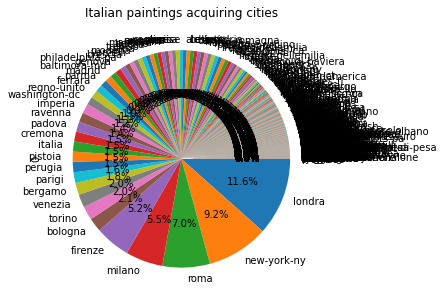

In [118]:
# We visualize the result as a pie plot
import matplotlib.pyplot as plt
df.plot.pie(subplots=True, legend=False, autopct='%.1f%%', counterclock=False, figsize=(7,5))
plt.title('Italian paintings acquiring cities')
plt.show()

In [119]:
# We adjust the result in order to visualize only the most relevant cities
most_relevant_acquiring_cities = dict()
others = list()
for k,v in sorted_acquiring_city_dict.items():
    if v >= 270:
        most_relevant_acquiring_cities[k] = v
    else:
        others.append(v)

most_relevant_acquiring_cities['others'] = sum(others)
print(most_relevant_acquiring_cities)

{'londra': 1258, 'new-york-ny': 999, 'roma': 765, 'milano': 603, 'firenze': 568, 'others': 6672}


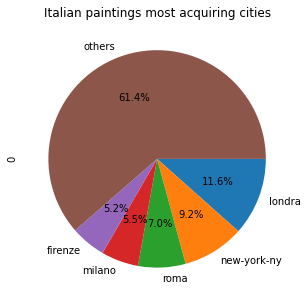

In [120]:
df = pd.DataFrame.from_dict(most_relevant_acquiring_cities, orient='index')

df.plot.pie(subplots=True, legend=False, autopct='%.1f%%', counterclock=False, figsize=(7,5))
plt.title('Italian paintings most acquiring cities')
plt.show()

In [121]:
# We Format the data in a format compliant with our Javascript libraries for the website visualizations
cities = list()
for k,v in most_relevant_acquiring_cities.items():
    cities.append('{\n "city"' + ':' + '"' + k[0].upper() + k[1:] + '"' + ',' +
                '\n"paintings"' + ':' + str(v) +'\n}')

viz_data = "[" + ",".join(cities) + "]"
print(viz_data)

[{
 "city":"Londra",
"paintings":1258
},{
 "city":"New-york-ny",
"paintings":999
},{
 "city":"Roma",
"paintings":765
},{
 "city":"Milano",
"paintings":603
},{
 "city":"Firenze",
"paintings":568
},{
 "city":"Others",
"paintings":6672
}]


**GIVING CITIES**
In this second section, we analyse the cities from the point of view of their giving away of Italian paintings.
The process is exactly the same as above, with the only modification of the data variable we apply it.

In [122]:
giving_city_dict = Counter(giving_city_list)
print('Times a city gave an Italian Paintings:', giving_city_dict)

Times a city gave an Italian Paintings: Counter({'londra': 1395, 'new-york-ny': 1139, 'roma': 951, 'firenze': 916, 'milano': 662, 'venezia': 355, 'parigi': 306, 'regno-unito': 263, 'torino': 242, 'bologna': 202, 'bergamo': 169, 'italia': 160, 'ferrara': 159, 'verona': 143, 'cremona': 138, 'perugia': 116, 'padova': 102, 'pistoia': 99, 'imperia': 94, 'ravenna': 94, 'genova': 90, 'assisi': 85, 'philadelphia-pa': 84, 'berlino': 81, 'vienna': 80, 'parma': 75, 'brescia': 62, 'mantova': 61, 'richmond': 48, 'lucca': 48, 'modena': 48, 'siena': 48, 'treviso': 45, 'arezzo': 45, 'rimini': 43, 'pisa': 41, 'crema': 41, 'francavilla-di-sicilia': 41, 'cazzago-san-martino': 41, 'ancona': 40, 'belluno': 40, 'varese': 40, 'cagliari': 39, 'como': 39, 'messina': 39, 'pordenone': 39, 'alessandria': 38, 'chieti': 38, 'cuneo': 38, 'emilia-romagna': 38, 'fi': 38, 'latina': 38, 'marche': 38, 'pesaro e urbino': 38, 'reggio nellemilia': 38, 'veneto': 38, 'vercelli': 38, 'monaco-di-baviera': 36, 'amsterdam': 34, '

In [123]:
# We sort the result
sorted_giving_city_dict = dict()
sorted_giving_city = sorted(giving_city_dict.items(), key=lambda x: x[1], reverse=True)
for i in sorted_giving_city:
    sorted_giving_city_dict[i[0]] = i[1]
print(sorted_giving_city_dict)

{'londra': 1395, 'new-york-ny': 1139, 'roma': 951, 'firenze': 916, 'milano': 662, 'venezia': 355, 'parigi': 306, 'regno-unito': 263, 'torino': 242, 'bologna': 202, 'bergamo': 169, 'italia': 160, 'ferrara': 159, 'verona': 143, 'cremona': 138, 'perugia': 116, 'padova': 102, 'pistoia': 99, 'imperia': 94, 'ravenna': 94, 'genova': 90, 'assisi': 85, 'philadelphia-pa': 84, 'berlino': 81, 'vienna': 80, 'parma': 75, 'brescia': 62, 'mantova': 61, 'richmond': 48, 'lucca': 48, 'modena': 48, 'siena': 48, 'treviso': 45, 'arezzo': 45, 'rimini': 43, 'pisa': 41, 'crema': 41, 'francavilla-di-sicilia': 41, 'cazzago-san-martino': 41, 'ancona': 40, 'belluno': 40, 'varese': 40, 'cagliari': 39, 'como': 39, 'messina': 39, 'pordenone': 39, 'alessandria': 38, 'chieti': 38, 'cuneo': 38, 'emilia-romagna': 38, 'fi': 38, 'latina': 38, 'marche': 38, 'pesaro e urbino': 38, 'reggio nellemilia': 38, 'veneto': 38, 'vercelli': 38, 'monaco-di-baviera': 36, 'amsterdam': 34, 'washington-dc': 29, 'napoli': 27, 'stati-uniti-d

In [124]:
# We adjust the result in order to visualize only the most relevant cities
most_relevant_giving_cities = dict()
others = list()
for k,v in sorted_giving_city_dict.items():
    if v >= 150:
        most_relevant_giving_cities[k] = v
    else:
        others.append(v)

most_relevant_giving_cities['others'] = sum(others)
print(most_relevant_giving_cities)

{'londra': 1395, 'new-york-ny': 1139, 'roma': 951, 'firenze': 916, 'milano': 662, 'venezia': 355, 'parigi': 306, 'regno-unito': 263, 'torino': 242, 'bologna': 202, 'bergamo': 169, 'italia': 160, 'ferrara': 159, 'others': 3957}


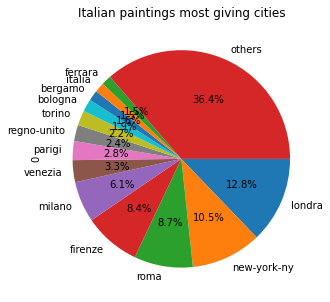

In [125]:
df = pd.DataFrame.from_dict(most_relevant_giving_cities, orient='index')

df.plot.pie(subplots=True, legend=False, autopct='%.1f%%', counterclock=False, figsize=(7,5))
plt.title('Italian paintings most giving cities')
plt.show()

In [126]:
# We format the data in a Javascript readable format
cities = list()
for k,v in most_relevant_giving_cities.items():
    cities.append('{\n "city"' + ':' + '"' + k[0].upper() + k[1:] + '"' + ',' +
                '\n"paintings"' + ':' + str(v) +'\n}')

viz_data = "[" + ",".join(cities) + "]"
print(viz_data)

[{
 "city":"Londra",
"paintings":1395
},{
 "city":"New-york-ny",
"paintings":1139
},{
 "city":"Roma",
"paintings":951
},{
 "city":"Firenze",
"paintings":916
},{
 "city":"Milano",
"paintings":662
},{
 "city":"Venezia",
"paintings":355
},{
 "city":"Parigi",
"paintings":306
},{
 "city":"Regno-unito",
"paintings":263
},{
 "city":"Torino",
"paintings":242
},{
 "city":"Bologna",
"paintings":202
},{
 "city":"Bergamo",
"paintings":169
},{
 "city":"Italia",
"paintings":160
},{
 "city":"Ferrara",
"paintings":159
},{
 "city":"Others",
"paintings":3957
}]


In [127]:
# Visualization
index = list()
acquired_paintings = list()
given_paintings = list()
for k,v in most_relevant_acquiring_cities.items():
    index.append(k)
    acquired_paintings.append(v)

for city in index:
    if city in giving_city_dict.keys():
        given_paintings.append(giving_city_dict[city])
while len(acquired_paintings) != len(given_paintings):
    given_paintings.append(0) # Here we put a random number in order to have same lenght lists for the visualizations,
                              # but we will adjust the exact data in a secondary moment.

print(index)

['londra', 'new-york-ny', 'roma', 'milano', 'firenze', 'others']


In [128]:
print(acquired_paintings)

[1258, 999, 765, 603, 568, 6672]


In [129]:
print(given_paintings)

[1395, 1139, 951, 662, 916, 0]


In [130]:
acq_cities_dict = dict(zip(index, acquired_paintings))
print(acq_cities_dict)

{'londra': 1258, 'new-york-ny': 999, 'roma': 765, 'milano': 603, 'firenze': 568, 'others': 6672}


In [131]:
giv_cities_dict = dict(zip(index, given_paintings))
print(giv_cities_dict)

{'londra': 1395, 'new-york-ny': 1139, 'roma': 951, 'milano': 662, 'firenze': 916, 'others': 0}


In [132]:
# We format data in a Javascript readable format.
# Here we have data formatted in order to visualize the amount of paintings acquired and given by each institution.
ag_cities = list()
for k,v in acq_cities_dict.items():
    ag_cities.append('{\n "city"' + ':' + '"' + k[0].upper() + k[1:] + '"' + ',' +
                        '\n"acq_paintings"' + ':' + str(v) + ',' + '\n"giv_paintings"' + ':' + str(giv_cities_dict[k]) +'\n}')

ag_data = "[" + ",".join(ag_cities) + "]"
print(ag_data)

[{
 "city":"Londra",
"acq_paintings":1258,
"giv_paintings":1395
},{
 "city":"New-york-ny",
"acq_paintings":999,
"giv_paintings":1139
},{
 "city":"Roma",
"acq_paintings":765,
"giv_paintings":951
},{
 "city":"Milano",
"acq_paintings":603,
"giv_paintings":662
},{
 "city":"Firenze",
"acq_paintings":568,
"giv_paintings":916
},{
 "city":"Others",
"acq_paintings":6672,
"giv_paintings":0
}]


In [133]:
# We format data in a Javascript readable format.
# Here we have data formatted in order to visualize the amount of exchangings acts recorded by each institution.
ag_cities = list()
for k,v in acq_cities_dict.items():
    ag_cities.append('{\n "city"' + ':' + '"' + k[0].upper() + k[1:] + '"' + ',' +
                        '\n"exhcangings"' + ':' + str(v + giv_cities_dict[k]) + '\n}')

ag_data = "[" + ",".join(ag_cities) + "]"
print(ag_data)

[{
 "city":"Londra",
"exhcangings":2653
},{
 "city":"New-york-ny",
"exhcangings":2138
},{
 "city":"Roma",
"exhcangings":1716
},{
 "city":"Milano",
"exhcangings":1265
},{
 "city":"Firenze",
"exhcangings":1484
},{
 "city":"Others",
"exhcangings":6672
}]


**RELATIONSHIPS AMONG CITIES**
Then, in order to inspect the relationships between different cities in exchanging Italian paintings, we use the same method to count the how many times they appear together in an exchanging act.

In [138]:
acquiring_giving_cities = list()
for i in data['results']['bindings']:
    if 'acquiring_city' in i and 'giving_city' in i:  # to escape the case in which they are unknown
        tuple = (district_strip(url_strip(i['acquiring_city']['value'])), district_strip(url_strip(i['giving_city']['value'])))
        acquiring_giving_cities.append(tuple)

cities_relationship = Counter(acquiring_giving_cities)
print('Times two cities exchanged Italian paintings', cities_relationship)

Times two cities exchanged Italian paintings Counter({('londra', 'londra'): 418, ('roma', 'roma'): 304, ('new-york-ny', 'new-york-ny'): 280, ('firenze', 'firenze'): 170, ('new-york-ny', 'londra'): 158, ('new-york-ny', 'firenze'): 147, ('londra', 'regno-unito'): 143, ('bergamo', 'bergamo'): 133, ('milano', 'milano'): 126, ('washington-dc', 'new-york-ny'): 102, ('venezia', 'venezia'): 79, ('baltimora-md', 'roma'): 77, ('philadelphia-pa', 'philadelphia-pa'): 72, ('roma', 'londra'): 64, ('firenze', 'londra'): 59, ('milano', 'firenze'): 53, ('parigi', 'parigi'): 52, ('roma', 'firenze'): 50, ('londra', 'new-york-ny'): 49, ('regno-unito', 'regno-unito'): 47, ('milano', 'londra'): 42, ('firenze', 'roma'): 41, ('milano', 'roma'): 39, ('ferrara', 'ferrara'): 39, ('londra', 'venezia'): 38, ('londra', 'roma'): 36, ('londra', 'firenze'): 36, ('roma', 'milano'): 36, ('firenze', 'milano'): 31, ('new-york-ny', 'roma'): 30, ('londra', 'parigi'): 30, ('new-york-ny', 'parigi'): 28, ('parigi', 'milano'): 

In [139]:
#Visualize the relationship as a Python graph
import networkx as nx
G = nx.Graph()

for k,v in cities_relationship.items():
    G.add_nodes_from(k)
    G.add_edge(k[0], k[1], weight=v)
print(G.edges(data=True))

[('firenze', 'firenze', {'weight': 170}), ('firenze', 'londra', {'weight': 59}), ('firenze', 'new-york-ny', {'weight': 20}), ('firenze', 'chambery', {'weight': 12}), ('firenze', 'genova', {'weight': 14}), ('firenze', 'venezia', {'weight': 22}), ('firenze', 'milano', {'weight': 31}), ('firenze', 'torino', {'weight': 13}), ('firenze', 'roma', {'weight': 41}), ('firenze', 'stoccolma', {'weight': 3}), ('firenze', 'connecticut', {'weight': 1}), ('firenze', 'new-york', {'weight': 3}), ('firenze', 'stati-uniti-damerica', {'weight': 1}), ('firenze', 'la-spezia', {'weight': 2}), ('firenze', 'baltimora-md', {'weight': 4}), ('firenze', 'lugano', {'weight': 1}), ('firenze', 'alessandria', {'weight': 2}), ('firenze', 'ancona', {'weight': 2}), ('firenze', 'belluno', {'weight': 2}), ('firenze', 'bologna', {'weight': 10}), ('firenze', 'brescia', {'weight': 2}), ('firenze', 'cagliari', {'weight': 2}), ('firenze', 'chieti', {'weight': 2}), ('firenze', 'como', {'weight': 2}), ('firenze', 'cremona', {'wei

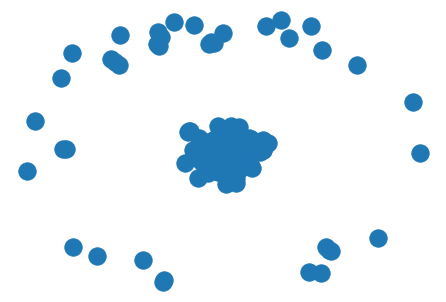

In [140]:
nx.draw(G)

**INSTITUTIONS**
After having inspected exchanging acts from the point of view of cities, we want to analyse provenance from a more detailed perspective: the one regarding institutions.

In [165]:
import re


paintings_list = list()
provenance_list = list()
acquiring_inst_list = list()
giving_inst_list = list()
for i in data['results']['bindings']:
    paintings_list.append(i['art_item']['value'])
    provenance_list.append(re.split("/", i['provenance']['value'])[-1])
    if url_strip(i['acquiring_inst']['value']) == '':
        acquiring_inst_list.append('unknown istitution')
    elif url_strip(i['giving_inst']['value']) == '':
        giving_inst_list.append('unknown istitution')
    else:
        acquiring_inst_list.append(re.split("/", i['acquiring_inst']['value'])[-1])
        giving_inst_list.append(re.split("/", i['giving_inst']['value'])[-1])

df = pd.DataFrame(list(zip(paintings_list, provenance_list, acquiring_inst_list, giving_inst_list)),
                  columns =['painting', 'provenance_nr', 'acquiring_inst', 'giving_inst'])
print(df)

                                              painting provenance_nr  \
0      https://w3id.org/zericatalog/artwork/16528/item  provenance-1   
1      https://w3id.org/zericatalog/artwork/16537/item  provenance-3   
2      https://w3id.org/zericatalog/artwork/16537/item  provenance-1   
3      https://w3id.org/zericatalog/artwork/16537/item  provenance-2   
4      https://w3id.org/zericatalog/artwork/16540/item  provenance-2   
...                                                ...           ...   
10860  https://w3id.org/zericatalog/artwork/49214/item  provenance-1   
10861  https://w3id.org/zericatalog/artwork/49214/item  provenance-2   
10862  https://w3id.org/zericatalog/artwork/49214/item  provenance-3   
10863  https://w3id.org/zericatalog/artwork/49218/item  provenance-1   
10864  https://w3id.org/zericatalog/artwork/49226/item  provenance-1   

                                          acquiring_inst  \
0      palazzo-degli-uffizi-galleria-degli-uffizi-fir...   
1              

**ACQUIRING INSTITUTIONS**
Counting how many times an institution has acquired and given away an Italian painting.

In [166]:
acquiring_inst = Counter(acquiring_inst_list)
print('Times an institution acquired an Italian Paintings:', acquiring_inst)

Times an institution acquired an Italian Paintings: Counter({'collezione-privata-italia': 2378, 'mercato-antiquario-italia': 1078, 'asta-christies-londra': 355, 'collezione-privata-roma': 254, 'asta-sothebys-londra': 237, 'unknown istitution': 220, 'collezione-sh-kress-new-york-ny': 198, 'pinacoteca-dellaccademia-carrara-bergamo': 139, 'asta-sothebys-new-york-ny': 127, 'asta-christies-new-york-ny': 127, 'national-gallery-of-art-washington-dc': 120, 'mercato-antiquario-milano': 118, 'collezione-privata-londra': 112, 'mercato-antiquario-firenze': 106, 'the-walters-art-museum-baltimora-md': 85, 'collezione-privata-milano': 80, 'contini-bonacossi-firenze': 78, 'mercato-antiquario-roma': 74, 'philadelphia-museum-of-art-philadelphia-pa': 72, 'museo-thyssenbornemisza-madrid': 54, 'national-gallery-londra': 48, 'colnaghi-londra': 45, 'palazzo-degli-uffizi-galleria-degli-uffizi-firenze': 44, 'asta-farsetti-prato': 44, 'mercato-antiquario-reggio-nellemilia': 44, 'collezione-privata-new-york-ny':

In [167]:
sorted_acquiring_inst = dict()
sorted_inst = sorted(acquiring_inst.items(), key=lambda x: x[1], reverse=True)
for i in sorted_inst:
    sorted_acquiring_inst[i[0]] = i[1]
print(sorted_acquiring_inst)

{'collezione-privata-italia': 2378, 'mercato-antiquario-italia': 1078, 'asta-christies-londra': 355, 'collezione-privata-roma': 254, 'asta-sothebys-londra': 237, 'unknown istitution': 220, 'collezione-sh-kress-new-york-ny': 198, 'pinacoteca-dellaccademia-carrara-bergamo': 139, 'asta-sothebys-new-york-ny': 127, 'asta-christies-new-york-ny': 127, 'national-gallery-of-art-washington-dc': 120, 'mercato-antiquario-milano': 118, 'collezione-privata-londra': 112, 'mercato-antiquario-firenze': 106, 'the-walters-art-museum-baltimora-md': 85, 'collezione-privata-milano': 80, 'contini-bonacossi-firenze': 78, 'mercato-antiquario-roma': 74, 'philadelphia-museum-of-art-philadelphia-pa': 72, 'museo-thyssenbornemisza-madrid': 54, 'national-gallery-londra': 48, 'colnaghi-londra': 45, 'palazzo-degli-uffizi-galleria-degli-uffizi-firenze': 44, 'asta-farsetti-prato': 44, 'mercato-antiquario-reggio-nellemilia': 44, 'collezione-privata-new-york-ny': 42, 'mercato-antiquario-stoccolma': 41, 'banco-di-santo-spi

In [168]:
df = pd.DataFrame.from_dict(sorted_acquiring_inst, orient='index')
print(df)

                                      0
collezione-privata-italia          2378
mercato-antiquario-italia          1078
asta-christies-londra               355
collezione-privata-roma             254
asta-sothebys-londra                237
...                                 ...
galleria-a-f-di-castro-roma           1
collezione-g-lockerlampson-londra     1
collezione-l-clark-londra             1
asta-sothebys-regno-unito             1
museo-di-palazzo-vecchio-firenze      1

[1740 rows x 1 columns]


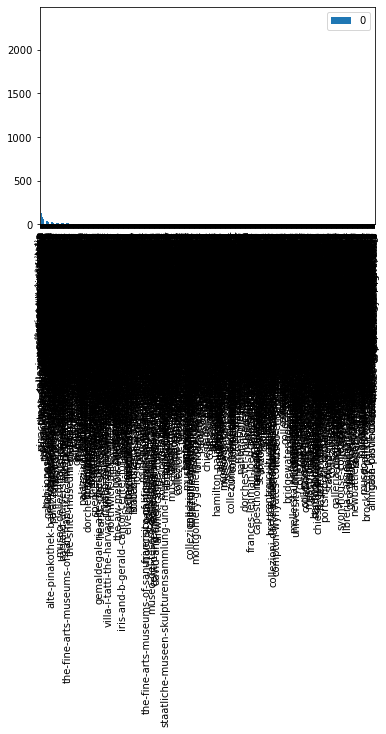

                                               0
collezione-privata-italia                   2378
mercato-antiquario-italia                   1078
asta-christies-londra                        355
collezione-privata-roma                      254
asta-sothebys-londra                         237
unknown istitution                           220
collezione-sh-kress-new-york-ny              198
pinacoteca-dellaccademia-carrara-bergamo     139
asta-sothebys-new-york-ny                    127
asta-christies-new-york-ny                   127
national-gallery-of-art-washington-dc        120
mercato-antiquario-milano                    118
collezione-privata-londra                    112
mercato-antiquario-firenze                   106
the-walters-art-museum-baltimora-md           85
collezione-privata-milano                     80
contini-bonacossi-firenze                     78
mercato-antiquario-roma                       74
philadelphia-museum-of-art-philadelphia-pa    72
museo-thyssenbornemi

In [169]:
import matplotlib.pyplot as plt
df.plot.bar()
plt.show()

# Adjust the graph to make it visually understandable
import operator
most_relevant_acquiring_inst = dict(sorted(acquiring_inst.items(), key=operator.itemgetter(1), reverse=True)[:20])

df = pd.DataFrame.from_dict(most_relevant_acquiring_inst, orient='index')
print(df)

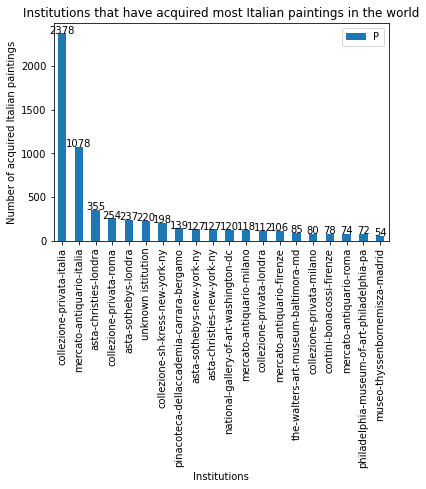

In [170]:
# Visualize most relevant institutions for acquired Italian paintings
# Functions to add value to each bar
x = list()
y = list()
for k,v in most_relevant_acquiring_inst.items():
    x.append(k)
    y.append(v)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

df.plot.bar(legend=None)
addlabels(x, y)
plt.xlabel('Institutions')
plt.ylabel('Number of acquired Italian paintings')
plt.title('Institutions that have acquired most Italian paintings in the world')
plt.legend('Painting')
plt.show()

In [171]:
# Formatting data in a Javascript-readable format
institutions = list()
for k,v in most_relevant_acquiring_inst.items():
    inst = re.sub("\-", " ", k).title()
    institutions.append('{\n "inst"' + ':' + '"' + inst + '"' + ',' +
                '\n"paintings"' + ':' + str(v) +'\n}')

viz_data = "[" + ",".join(institutions) + "]"
print(viz_data)

[{
 "inst":"Collezione Privata Italia",
"paintings":2378
},{
 "inst":"Mercato Antiquario Italia",
"paintings":1078
},{
 "inst":"Asta Christies Londra",
"paintings":355
},{
 "inst":"Collezione Privata Roma",
"paintings":254
},{
 "inst":"Asta Sothebys Londra",
"paintings":237
},{
 "inst":"Unknown Istitution",
"paintings":220
},{
 "inst":"Collezione Sh Kress New York Ny",
"paintings":198
},{
 "inst":"Pinacoteca Dellaccademia Carrara Bergamo",
"paintings":139
},{
 "inst":"Asta Sothebys New York Ny",
"paintings":127
},{
 "inst":"Asta Christies New York Ny",
"paintings":127
},{
 "inst":"National Gallery Of Art Washington Dc",
"paintings":120
},{
 "inst":"Mercato Antiquario Milano",
"paintings":118
},{
 "inst":"Collezione Privata Londra",
"paintings":112
},{
 "inst":"Mercato Antiquario Firenze",
"paintings":106
},{
 "inst":"The Walters Art Museum Baltimora Md",
"paintings":85
},{
 "inst":"Collezione Privata Milano",
"paintings":80
},{
 "inst":"Contini Bonacossi Firenze",
"paintings":78
},{
 "

**GIVING**

In [172]:
giving_inst = Counter(giving_inst_list)
print('Times an institution gave an Italian Paintings:', giving_inst)

Times an institution gave an Italian Paintings: Counter({'collezione-privata-italia': 1517, 'mercato-antiquario-italia': 616, 'asta-sothebys-londra': 364, 'asta-christies-londra': 336, 'collezione-sh-kress-new-york-ny': 305, 'mercato-antiquario-milano': 205, 'contini-bonacossi-firenze': 186, 'unknown istitution': 184, 'mercato-antiquario-firenze': 106, 'asta-sothebys-new-york-ny': 101, 'collezione-cook-londra': 94, 'f-mont-new-york-ny': 94, 'mercato-antiquario-roma': 92, 'collezione-i-brass-venezia': 87, 'galleria-menaguale-verona': 87, 'sestieri-roma': 84, 'mercato-antiquario-assisi': 83, 'collezione-m-massarenti-roma': 77, 'collezione-jg-johnson-philadelphia-pa': 69, 'collezione-costabili-ferrara': 67, 'asta-finarte-milano': 59, 'collezione-carrara-bergamo': 59, 'asta-christies-new-york-ny': 57, 'asta-pandolfini-firenze': 55, 'moratilla-parigi': 51, 'baroni-parigi': 50, 'mercato-antiquario-verona': 49, 'faldella-bologna': 48, 'mercato-antiquario-torino': 48, 'colnaghi-londra': 47, 'g

In [173]:
sorted_giving_inst = dict()
sorted_inst = sorted(giving_inst.items(), key=lambda x: x[1], reverse=True)
for i in sorted_inst:
    sorted_giving_inst[i[0]] = i[1]
print(sorted_giving_inst)

{'collezione-privata-italia': 1517, 'mercato-antiquario-italia': 616, 'asta-sothebys-londra': 364, 'asta-christies-londra': 336, 'collezione-sh-kress-new-york-ny': 305, 'mercato-antiquario-milano': 205, 'contini-bonacossi-firenze': 186, 'unknown istitution': 184, 'mercato-antiquario-firenze': 106, 'asta-sothebys-new-york-ny': 101, 'collezione-cook-londra': 94, 'f-mont-new-york-ny': 94, 'mercato-antiquario-roma': 92, 'collezione-i-brass-venezia': 87, 'galleria-menaguale-verona': 87, 'sestieri-roma': 84, 'mercato-antiquario-assisi': 83, 'collezione-m-massarenti-roma': 77, 'collezione-jg-johnson-philadelphia-pa': 69, 'collezione-costabili-ferrara': 67, 'asta-finarte-milano': 59, 'collezione-carrara-bergamo': 59, 'asta-christies-new-york-ny': 57, 'asta-pandolfini-firenze': 55, 'moratilla-parigi': 51, 'baroni-parigi': 50, 'mercato-antiquario-verona': 49, 'faldella-bologna': 48, 'mercato-antiquario-torino': 48, 'colnaghi-londra': 47, 'gasparrini-roma': 46, 'bellesi-londra': 45, 'collezione-p

In [174]:
df = pd.DataFrame.from_dict(sorted_giving_inst, orient='index')
print(df)

                                             0
collezione-privata-italia                 1517
mercato-antiquario-italia                  616
asta-sothebys-londra                       364
asta-christies-londra                      336
collezione-sh-kress-new-york-ny            305
...                                        ...
collezione-f-gentili-di-giuseppe-parigi      1
asta-sothebys-regno-unito                    1
collezione-sir-a-fitz-george-regno-unito     1
collezione-g-lockerlampson-londra            1
collezione-l-clark-londra                    1

[2268 rows x 1 columns]


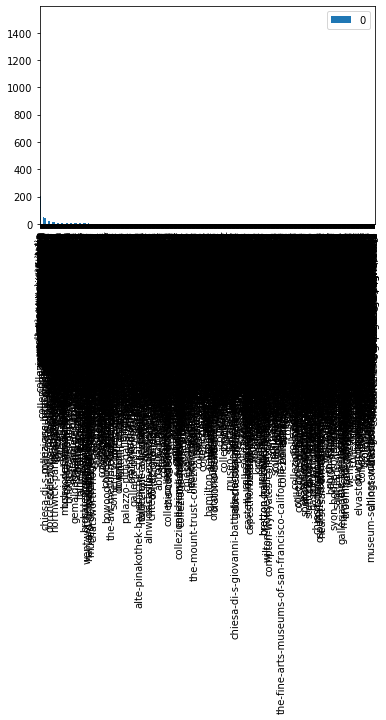

In [176]:
df.plot.bar()
plt.show()

In [177]:
# Adjust the graph to make it visually understandable
most_relevant_giving_inst = dict(sorted(giving_inst.items(), key=operator.itemgetter(1), reverse=True)[:20])

df = pd.DataFrame.from_dict(most_relevant_giving_inst, orient='index')
print(df)

                                          0
collezione-privata-italia              1517
mercato-antiquario-italia               616
asta-sothebys-londra                    364
asta-christies-londra                   336
collezione-sh-kress-new-york-ny         305
mercato-antiquario-milano               205
contini-bonacossi-firenze               186
unknown istitution                      184
mercato-antiquario-firenze              106
asta-sothebys-new-york-ny               101
collezione-cook-londra                   94
f-mont-new-york-ny                       94
mercato-antiquario-roma                  92
collezione-i-brass-venezia               87
galleria-menaguale-verona                87
sestieri-roma                            84
mercato-antiquario-assisi                83
collezione-m-massarenti-roma             77
collezione-jg-johnson-philadelphia-pa    69
collezione-costabili-ferrara             67


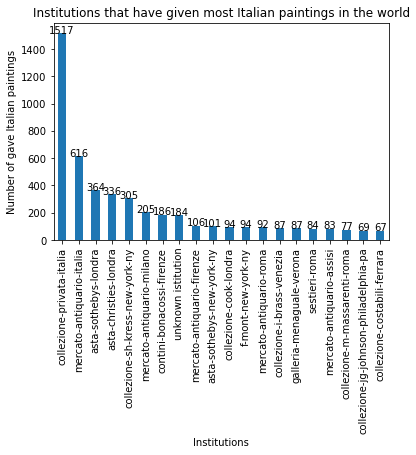

In [178]:
# Visualize most relevant institutions for given Italian paintings
# Functions to add value to each bar
x = list()
y = list()
for k,v in most_relevant_giving_inst.items():
    x.append(k)
    y.append(v)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

df.plot.bar(legend=None)
addlabels(x, y)
plt.xlabel('Institutions')
plt.ylabel('Number of gave Italian paintings')
plt.title('Institutions that have given most Italian paintings in the world')
plt.show()

In [179]:
# Formatting data in a Javascript-readable format
institutions = list()
for k,v in most_relevant_giving_inst.items():
    inst = re.sub("\-", " ", k).title()
    institutions.append('{\n "inst"' + ':' + '"' + inst + '"' + ',' +
                '\n"paintings"' + ':' + str(v) +'\n}')

viz_data = "[" + ",".join(institutions) + "]"
print(viz_data)

[{
 "inst":"Collezione Privata Italia",
"paintings":1517
},{
 "inst":"Mercato Antiquario Italia",
"paintings":616
},{
 "inst":"Asta Sothebys Londra",
"paintings":364
},{
 "inst":"Asta Christies Londra",
"paintings":336
},{
 "inst":"Collezione Sh Kress New York Ny",
"paintings":305
},{
 "inst":"Mercato Antiquario Milano",
"paintings":205
},{
 "inst":"Contini Bonacossi Firenze",
"paintings":186
},{
 "inst":"Unknown Istitution",
"paintings":184
},{
 "inst":"Mercato Antiquario Firenze",
"paintings":106
},{
 "inst":"Asta Sothebys New York Ny",
"paintings":101
},{
 "inst":"Collezione Cook Londra",
"paintings":94
},{
 "inst":"F Mont New York Ny",
"paintings":94
},{
 "inst":"Mercato Antiquario Roma",
"paintings":92
},{
 "inst":"Collezione I Brass Venezia",
"paintings":87
},{
 "inst":"Galleria Menaguale Verona",
"paintings":87
},{
 "inst":"Sestieri Roma",
"paintings":84
},{
 "inst":"Mercato Antiquario Assisi",
"paintings":83
},{
 "inst":"Collezione M Massarenti Roma",
"paintings":77
},{
 "inst"

In [180]:
#Visualize differences in acquiring and giving paintings among most relevan institutions
index = list()
acquired_paintings = list()
given_paintings = list()
for k,v in most_relevant_acquiring_inst.items():
    index.append(k)
    acquired_paintings.append(v)

for inst in index:
    if inst in giving_inst.keys():
        given_paintings.append(giving_inst[inst])

print(index)

['collezione-privata-italia', 'mercato-antiquario-italia', 'asta-christies-londra', 'collezione-privata-roma', 'asta-sothebys-londra', 'unknown istitution', 'collezione-sh-kress-new-york-ny', 'pinacoteca-dellaccademia-carrara-bergamo', 'asta-sothebys-new-york-ny', 'asta-christies-new-york-ny', 'national-gallery-of-art-washington-dc', 'mercato-antiquario-milano', 'collezione-privata-londra', 'mercato-antiquario-firenze', 'the-walters-art-museum-baltimora-md', 'collezione-privata-milano', 'contini-bonacossi-firenze', 'mercato-antiquario-roma', 'philadelphia-museum-of-art-philadelphia-pa', 'museo-thyssenbornemisza-madrid']


In [181]:
print(acquired_paintings)

[2378, 1078, 355, 254, 237, 220, 198, 139, 127, 127, 120, 118, 112, 106, 85, 80, 78, 74, 72, 54]


In [182]:
print(given_paintings)

[1517, 616, 336, 42, 364, 184, 305, 1, 101, 57, 23, 205, 28, 106, 2, 26, 186, 92, 2]


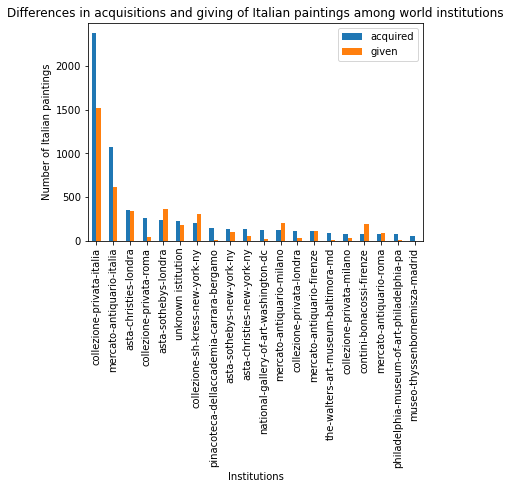

In [183]:
while len(acquired_paintings) != len(given_paintings):
    given_paintings.append(0)

df = pd.DataFrame({'acquired': acquired_paintings,
                   'given': given_paintings}, index=index)
df.plot.bar()
plt.xlabel('Institutions')
plt.ylabel('Number of Italian paintings')
plt.title('Differences in acquisitions and giving of Italian paintings among world institutions')
plt.show()

In [184]:
# Data related to acquisition and givings:
acq_inst_dict = dict(zip(index, acquired_paintings))
print(acq_inst_dict)
giv_inst_dict = dict(zip(index, given_paintings))
print(giv_inst_dict)

ag_inst = list()
for k,v in acq_inst_dict.items():
    inst = re.sub("\-", " ", k).title()
    ag_inst.append('{\n "institution"' + ':' + '"' + inst + '"' + ',' +
                        '\n"acq_paintings"' + ':' + str(v) + ',' + '\n"giv_paintings"' + ':' + str(giv_inst_dict[k]) +'\n}')

ag_data = "[" + ",".join(ag_inst) + "]"
print(ag_data)

{'collezione-privata-italia': 2378, 'mercato-antiquario-italia': 1078, 'asta-christies-londra': 355, 'collezione-privata-roma': 254, 'asta-sothebys-londra': 237, 'unknown istitution': 220, 'collezione-sh-kress-new-york-ny': 198, 'pinacoteca-dellaccademia-carrara-bergamo': 139, 'asta-sothebys-new-york-ny': 127, 'asta-christies-new-york-ny': 127, 'national-gallery-of-art-washington-dc': 120, 'mercato-antiquario-milano': 118, 'collezione-privata-londra': 112, 'mercato-antiquario-firenze': 106, 'the-walters-art-museum-baltimora-md': 85, 'collezione-privata-milano': 80, 'contini-bonacossi-firenze': 78, 'mercato-antiquario-roma': 74, 'philadelphia-museum-of-art-philadelphia-pa': 72, 'museo-thyssenbornemisza-madrid': 54}
{'collezione-privata-italia': 1517, 'mercato-antiquario-italia': 616, 'asta-christies-londra': 336, 'collezione-privata-roma': 42, 'asta-sothebys-londra': 364, 'unknown istitution': 184, 'collezione-sh-kress-new-york-ny': 305, 'pinacoteca-dellaccademia-carrara-bergamo': 1, 'a

In [186]:
# Counting how many times two institutions appear together in an act of provenance
import networkx as nx

acquiring_giving_institutions = list()
for i in data['results']['bindings']:
    tuple = (re.split("/", i['acquiring_inst']['value'])[-1], re.split("/", i['giving_inst']['value'])[-1])
    acquiring_giving_institutions.append(tuple)

institutions_relationship = Counter(acquiring_giving_institutions)
print('Times two institutions exchanged Italian paintings', institutions_relationship)

Times two institutions exchanged Italian paintings Counter({('mercato-antiquario-italia', 'collezione-privata-italia'): 902, ('collezione-privata-italia', 'mercato-antiquario-italia'): 451, ('collezione-privata-italia', 'asta-sothebys-londra'): 164, ('collezione-privata-italia', 'mercato-antiquario-milano'): 164, ('collezione-sh-kress-new-york-ny', 'contini-bonacossi-firenze'): 102, ('national-gallery-of-art-washington-dc', 'collezione-sh-kress-new-york-ny'): 90, ('collezione-privata-roma', 'collezione-privata-italia'): 82, ('collezione-privata-londra', 'collezione-privata-italia'): 82, ('collezione-privata-italia', 'asta-christies-londra'): 82, ('collezione-privata-italia', 'mercato-antiquario-firenze'): 82, ('collezione-privata-italia', 'collezione-i-brass-venezia'): 82, ('collezione-privata-italia', 'mercato-antiquario-assisi'): 82, ('mercato-antiquario-firenze', 'collezione-privata-italia'): 82, ('collezione-privata-italia', 'galleria-menaguale-verona'): 82, ('the-walters-art-museu

In [188]:
#Visualize the relationship as a Python graph

G = nx.Graph()

for k,v in institutions_relationship.items():
    G.add_nodes_from(k)
    G.add_edge(k[0], k[1], weight=v)
print(G.edges(data=True))

[('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'palazzo-uguccioni-firenze', {'weight': 1}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'collezione-manfrin-venezia', {'weight': 1}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'nave-aurora-italia', {'weight': 1}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'collezione-feroni-firenze', {'weight': 6}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'contini-bonacossi-firenze', {'weight': 6}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'ambasciata-ditalia-washington-dc', {'weight': 1}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'palazzo-pitti-galleria-palatina-firenze', {'weight': 2}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'galleria-dellaccademia-firenze', {'weight': 1}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'chiesa-di-s-caterina-pisa', {'weight': 1}), ('palazzo-degli-uffizi-galleria-degli-uffizi-firenze', 'palazzo-pitti-galleria-

In [189]:
restricted_G = nx.Graph()

for k,v in institutions_relationship.items():
    if v > 80:
        restricted_G.add_nodes_from(k)
        restricted_G.add_edge(k[0], k[1], weight=v)
print(restricted_G.edges(data=True))

[('national-gallery-of-art-washington-dc', 'collezione-sh-kress-new-york-ny', {'weight': 90}), ('collezione-sh-kress-new-york-ny', 'contini-bonacossi-firenze', {'weight': 102}), ('collezione-privata-roma', 'collezione-privata-italia', {'weight': 82}), ('collezione-privata-italia', 'collezione-privata-londra', {'weight': 82}), ('collezione-privata-italia', 'asta-christies-londra', {'weight': 82}), ('collezione-privata-italia', 'mercato-antiquario-italia', {'weight': 451}), ('collezione-privata-italia', 'mercato-antiquario-firenze', {'weight': 82}), ('collezione-privata-italia', 'asta-sothebys-londra', {'weight': 164}), ('collezione-privata-italia', 'mercato-antiquario-milano', {'weight': 164}), ('collezione-privata-italia', 'collezione-i-brass-venezia', {'weight': 82}), ('collezione-privata-italia', 'mercato-antiquario-assisi', {'weight': 82}), ('collezione-privata-italia', 'galleria-menaguale-verona', {'weight': 82})]


In [190]:
direct_tree = list()

for n in restricted_G.nodes():
    for m in restricted_G.nodes():
        if restricted_G.has_edge(n,m):
            #children = list()
            w = str(restricted_G.get_edge_data(n,m)['weight'])
            inst1 = re.sub("\-", " ", n).title()
            inst2 = re.sub("\-", " ", m).title()
            #children.append("{name: " + "'" + inst2 + "'" + ", value: " + w + "}")
            direct_tree.append("{"+ '"from":' + '"' + inst1 + '", ' + '"to":' + '"' + inst2 + '", ' + '"value":' + w + "}")

viz_data = ",\n".join(direct_tree)
print(viz_data)

{"from":"National Gallery Of Art Washington Dc", "to":"Collezione Sh Kress New York Ny", "value":90},
{"from":"Collezione Sh Kress New York Ny", "to":"National Gallery Of Art Washington Dc", "value":90},
{"from":"Collezione Sh Kress New York Ny", "to":"Contini Bonacossi Firenze", "value":102},
{"from":"Contini Bonacossi Firenze", "to":"Collezione Sh Kress New York Ny", "value":102},
{"from":"Collezione Privata Roma", "to":"Collezione Privata Italia", "value":82},
{"from":"Collezione Privata Italia", "to":"Collezione Privata Roma", "value":82},
{"from":"Collezione Privata Italia", "to":"Collezione Privata Londra", "value":82},
{"from":"Collezione Privata Italia", "to":"Asta Christies Londra", "value":82},
{"from":"Collezione Privata Italia", "to":"Mercato Antiquario Italia", "value":451},
{"from":"Collezione Privata Italia", "to":"Mercato Antiquario Firenze", "value":82},
{"from":"Collezione Privata Italia", "to":"Asta Sothebys Londra", "value":164},
{"from":"Collezione Privata Italia",

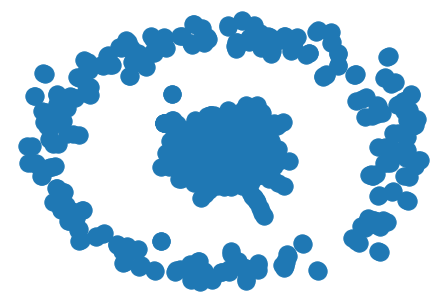

In [191]:
nx.draw(G)

### Explore the journey of some paintings (Giulia)

For the reader, it could be interesting to observe on a map the movement in space of some specific paintings. In particlar, I want to explore the 10 paintings that moved most.

In [196]:
# Finding 10 highest values
k = Counter(paintings_provenance_dict)
highest_10 = k.most_common(10)
pprint.pprint(highest_10)

[('https://w3id.org/zericatalog/artwork/45172/item', 17),
 ('https://w3id.org/zericatalog/artwork/16624/item', 10),
 ('https://w3id.org/zericatalog/artwork/38475/item', 10),
 ('https://w3id.org/zericatalog/artwork/43432/item', 10),
 ('https://w3id.org/zericatalog/artwork/44994/item', 10),
 ('https://w3id.org/zericatalog/artwork/48042/item', 10),
 ('https://w3id.org/zericatalog/artwork/80910/item', 10),
 ('https://w3id.org/zericatalog/artwork/33320/item', 9),
 ('https://w3id.org/zericatalog/artwork/35940/item', 9),
 ('https://w3id.org/zericatalog/artwork/36328/item', 9)]


In this specific case, I decided to directly query the Zeri SPARQL endpoint because I needed to retrieve GeoNames information.

In [198]:
# now I need to prepare the item iri for the query in zeri

find_provenance_highest_10 = list()
for k, v in highest_10:
    find_provenance_highest_10.append('<' + k + '>')
find_provenance = ' '.join(find_provenance_highest_10)

ssl._create_default_https_context = ssl._create_unverified_context

zeri_endpoint = SPARQLWrapper("http://data.fondazionezeri.unibo.it/sparql")

geo_places_query = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT ?art_item ?provenance ?acquiring_inst ?acquiring_city ?geo_acqcity ?giving_inst ?giving_city ?geo_givcity
WHERE {
    VALUES ?art_item {""" + find_provenance + """} . 
    ?provenance crm:P30_transferred_custody_of ?art_item .
    ?acquiring_inst crm:P29i_received_custody_through ?provenance .
    OPTIONAL {?acquiring_inst crm:P74_has_current_or_former_residence ?acquiring_city .
    OPTIONAL { ?acquiring_city owl:sameAs ?geo_acqcity FILTER regex(str(?geo_acqcity), "geonames") . }}
    ?provenance crm:P28_custody_surrendered_by ?giving_inst .
    OPTIONAL {?giving_inst crm:P74_has_current_or_former_residence ?giving_city .
    OPTIONAL { ?giving_city owl:sameAs ?geo_givcity FILTER regex(str(?geo_givcity), "geonames") . }}
  
    } ORDER BY ?provenance
"""

# set the query
zeri_endpoint.setQuery(geo_places_query)
# set the returned format
zeri_endpoint.setReturnFormat(JSON)
# get the results
zeri_provenance = zeri_endpoint.query().convert()
pprint.pprint(zeri_provenance)

{'head': {'vars': ['art_item',
                   'provenance',
                   'acquiring_inst',
                   'acquiring_city',
                   'geo_acqcity',
                   'giving_inst',
                   'giving_city',
                   'geo_givcity']},
 'results': {'bindings': [{'acquiring_city': {'type': 'uri',
                                              'value': 'https://w3id.org/zericatalog/place/coral-gables-fl'},
                           'acquiring_inst': {'type': 'uri',
                                              'value': 'https://w3id.org/zericatalog/lowe-art-museum-university-of-miami-coral-gables-fl'},
                           'art_item': {'type': 'uri',
                                        'value': 'https://w3id.org/zericatalog/artwork/16624/item'},
                           'giving_city': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/place/new-york-ny'},
                           'giving_

                                        'value': 'https://w3id.org/zericatalog/artwork/36328/item'},
                           'geo_acqcity': {'type': 'uri',
                                           'value': 'http://sws.geonames.org/2988507'},
                           'geo_givcity': {'type': 'uri',
                                           'value': 'http://sws.geonames.org/2988507'},
                           'giving_city': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/place/parigi'},
                           'giving_inst': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/galerie-trotti-parigi'},
                           'provenance': {'type': 'uri',
                                          'value': 'https://w3id.org/zericatalog/artwork/36328/provenance-5'}},
                          {'acquiring_city': {'type': 'uri',
                                              'value': '

                           'geo_acqcity': {'type': 'uri',
                                           'value': 'http://sws.geonames.org/2988507'},
                           'geo_givcity': {'type': 'uri',
                                           'value': 'http://sws.geonames.org/3054643'},
                           'giving_city': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/place/budapest'},
                           'giving_inst': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/collezione-m-von-nemes-budapest'},
                           'provenance': {'type': 'uri',
                                          'value': 'https://w3id.org/zericatalog/artwork/44994/provenance-7'}},
                          {'acquiring_city': {'type': 'uri',
                                              'value': 'https://w3id.org/zericatalog/place/budapest'},
                           'acquiring_inst

                           'giving_city': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/place/londra'},
                           'giving_inst': {'type': 'uri',
                                           'value': 'https://w3id.org/zericatalog/asta-christies-londra'},
                           'provenance': {'type': 'uri',
                                          'value': 'https://w3id.org/zericatalog/artwork/48042/provenance-8'}},
                          {'acquiring_city': {'type': 'uri',
                                              'value': 'https://w3id.org/zericatalog/place/londra'},
                           'acquiring_inst': {'type': 'uri',
                                              'value': 'https://w3id.org/zericatalog/asta-christies-londra'},
                           'art_item': {'type': 'uri',
                                        'value': 'https://w3id.org/zericatalog/artwork/48042/item'},
                     

**Disclaimer**: counterintuitively, if the provenance has the highest value it means that it's the starting point of the journey of the painting.

In order to organize the data, I have created two Class Object.

In [199]:
# Object Class for the final JSON
class StopsInfo:
    stop_n = 0
    city = ''
    latitude = ''
    longitude = ''

    def __init__(self, stop_n, city, latitude, longitude):
        self.stop_n = stop_n
        self.city = city
        self.latitude = latitude
        self.longitude = longitude

class ArtItemInfo:
    painting = ''
    stops = []

    def __init__(self, painting, stops):
        self.painting = painting
        self.stops = stops

and added two functions for actions that I repeat several times in this specifi part of the code.

In [200]:
def get_coord_info(place_info):
    """
    from access_geo_details, get name and coord
    """
    city = place_info.address
    latitude = place_info.lat
    longitude = place_info.lng
    return city, latitude, longitude


def find_acquiring_city_geo_info():
    """
    if the geo_id is present, retrieve information has did before; otherwise do so with the acquiring_city name
    """
    if 'geo_acqcity' in zeri_result:
        geo_id = url_strip(zeri_result['geo_acqcity']['value'])
        geo_info = access_geo_details(geo_id)
        coord_info = get_coord_info(geo_info)
        stop_list.append(StopsInfo(provenance_num, coord_info[0], coord_info[1], coord_info[2]))
    else:
        acquiring_city = district_strip(url_strip(zeri_result['acquiring_city']['value']))
        acqcity_id = get_geoid(acquiring_city)
        acqcity_info = access_geo_details(acqcity_id)
        coord_info = get_coord_info(acqcity_info)
        stop_list.append(StopsInfo(provenance_num, coord_info[0], coord_info[1], coord_info[2]))
    return stop_list

In [203]:
general_list = list()  # to store final objeect
for item in highest_10:
    stop_list = list()  # to store the object with info for each movement
    for zeri_result in zeri_provenance['results']['bindings']:
        art_item = zeri_result['art_item']['value']
        if item[0] == art_item:
            provenance = zeri_result['provenance']['value']
            provenance_num = int(url_strip(provenance).split('-')[-1])

            acquiring_inst = url_strip(zeri_result['acquiring_inst']['value'])
            if provenance_num == item[1]:  # if the provenance has the highest value it means that it's the starting point. So I need the giving city too
                giving_inst = url_strip(zeri_result['giving_inst']['value'])
                starting_point = provenance_num+1
                if giving_inst == '':  # sometimes the institution is unknown, and so is the city
                    stop_list.append(StopsInfo(starting_point, 'Unknown', 0, 0))
                else:
                    if 'geo_givcity' in zeri_result:
                        geo_id = url_strip(zeri_result['geo_givcity']['value'])
                        geo_info = access_geo_details(geo_id)
                        coord_info = get_coord_info(geo_info)
                        stop_list.append(StopsInfo(starting_point, coord_info[0], coord_info[1], coord_info[2]))
                    else:
                        giving_city = district_strip(url_strip(zeri_result['giving_city']['value']))
                        givcity_id = get_geoid(giving_city)
                        givcity_info = access_geo_details(givcity_id)
                        coord_info = get_coord_info(givcity_info)
                        stop_list.append(StopsInfo(starting_point, coord_info[0], coord_info[1], coord_info[2]))

                if acquiring_inst == '':  # sometimes the institution is unknown, and so is the city
                    stop_list.append(StopsInfo(provenance_num, 'Unknown', 0, 0))
                else:
                    find_acquiring_city_geo_info()
            else:
                if acquiring_inst == '':  # sometimes the institution is unknown, and so is the city
                    stop_list.append(StopsInfo(provenance_num, 'Unknown', 0, 0))
                else:
                    find_acquiring_city_geo_info()
    stop_list.sort(key=lambda x: x.stop_n, reverse=True)
    general_list.append(ArtItemInfo(art_item, stop_list))

with open('10_paintings.json', 'w') as fp:
    json.dump(general_list, fp, default=lambda x: x.__dict__)  # for each item it returns item.dict

In [204]:
trips_10 = read_json('10_paintings.json')
pprint.pprint(trips_10)

[{'painting': 'https://w3id.org/zericatalog/artwork/80910/item',
  'stops': [{'city': 'Unknown', 'latitude': 0, 'longitude': 0, 'stop_n': 18},
            {'city': 'London',
             'latitude': '51.50853',
             'longitude': '-0.12574',
             'stop_n': 17},
            {'city': 'United Kingdom',
             'latitude': '54.75844',
             'longitude': '-2.69531',
             'stop_n': 16},
            {'city': 'London',
             'latitude': '51.50853',
             'longitude': '-0.12574',
             'stop_n': 15},
            {'city': 'London',
             'latitude': '51.50853',
             'longitude': '-0.12574',
             'stop_n': 14},
            {'city': 'London',
             'latitude': '51.50853',
             'longitude': '-0.12574',
             'stop_n': 13},
            {'city': 'Unknown', 'latitude': 0, 'longitude': 0, 'stop_n': 12},
            {'city': 'Unknown', 'latitude': 0, 'longitude': 0, 'stop_n': 11},
            {'city': 'L

The intial plan was to show 10 different maps to represent the journey of each painting.

However, I understood that it was not much user-friendly, and decided to limit to 3 of them, adding general information about title, date of creation and image in order to create a small info card.

In [206]:
# Finding 3 highest values
highest_03 = highest_10[:3]
pprint.pprint(highest_03)

[('https://w3id.org/zericatalog/artwork/45172/item', 17),
 ('https://w3id.org/zericatalog/artwork/16624/item', 10),
 ('https://w3id.org/zericatalog/artwork/38475/item', 10)]


In [209]:
# now I need to prepare the item iri for the query in zeri

find_info_highest_03 = list()
for k, v in highest_03:
    find_info_highest_03.append('<' + k + '>')
find_info = ' '.join(find_info_highest_03)

ssl._create_default_https_context = ssl._create_unverified_context

zeri_endpoint = SPARQLWrapper("http://data.fondazionezeri.unibo.it/sparql")

find_info_query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX oaentry: <http://purl.org/emmedi/oaentry/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?art_item ?title_label ?time_span ?image
WHERE {
  VALUES ?art_item {""" + find_info + """} . 
  ?art_item foaf:depiction ?image .
  ?oaentry oaentry:describes ?art_item , ?artwork .
  ?oaentry crm:P102_has_title ?title .
  ?title rdfs:label ?title_label FILTER (lang(?title_label)='it') .

  ?artwork crm:P94i_was_created_by ?creation .
  ?creation crm:P4_has_time_span ?time_span .

}
"""

# set the query
zeri_endpoint.setQuery(find_info_query)
# set the returned format
zeri_endpoint.setReturnFormat(JSON)
# get the results
info_highest_03 = zeri_endpoint.query().convert()
pprint.pprint(info_highest_03)

{'head': {'vars': ['art_item', 'title_label', 'time_span', 'image']},
 'results': {'bindings': [{'art_item': {'type': 'uri',
                                        'value': 'https://w3id.org/zericatalog/artwork/45172/item'},
                           'image': {'type': 'uri',
                                     'value': 'http://catalogo.fondazionezeri.unibo.it/foto/120000/99200/98842.jpg'},
                           'time_span': {'type': 'uri',
                                         'value': 'https://w3id.org/zericatalog/date/1570-1588'},
                           'title_label': {'type': 'literal',
                                           'value': 'Caliari Paolo , Battesimo '
                                                    'di Cristo',
                                           'xml:lang': 'it'}},
                          {'art_item': {'type': 'uri',
                                        'value': 'https://w3id.org/zericatalog/artwork/45172/item'},
                       

In [211]:
# I prepare another Class Object

class CardInfo:
    painting = ''
    title = ''
    date = ''
    image = ''

    def __init__(self, painting, title, date, image):
        self.painting = painting
        self.title = title
        self.date = date
        self.image = image


paint_image_dict = dict()
for result in info_highest_03['results']['bindings']:
    art_item = result['art_item']['value']
    image = result['image']['value']
    paint_image_dict[art_item] = image

info_list = list()
for p, i in paint_image_dict.items():
    for result in info_highest_03['results']['bindings']:
        image = result['image']['value']
        if i == image:
            title_label = result['title_label']['value']
            time_span = url_strip(result['time_span']['value'])
            info_list.append(CardInfo(p, title_label, time_span, i))

with open('03_paintings_card.json', 'w') as fp:
    json.dump(info_list, fp, default=lambda x: x.__dict__)
    
card_03 = read_json('03_paintings_card.json')
pprint.pprint(card_03)

[{'date': '1570-1588',
  'image': 'http://catalogo.fondazionezeri.unibo.it/foto/160000/136000/135899.jpg',
  'painting': 'https://w3id.org/zericatalog/artwork/45172/item',
  'title': 'Caliari Paolo , Battesimo di Cristo'},
 {'date': '1530ca-1540ca',
  'image': 'http://catalogo.fondazionezeri.unibo.it/foto/120000/86000/85783.jpg',
  'painting': 'https://w3id.org/zericatalog/artwork/16624/item',
  'title': 'Del Conte Jacopino , Madonna con Bambino e san Giovannino'},
 {'date': '1550-1572',
  'image': 'http://catalogo.fondazionezeri.unibo.it/foto/120000/86400/86216.jpg',
  'painting': 'https://w3id.org/zericatalog/artwork/38475/item',
  'title': "Agnolo di Cosimo , Ritratto di Francesco de' Medici"}]
